In [1]:
#!pip install tensorflow==2.7.0

In [2]:
#pip install opencv-python-headless

In [3]:
from distutils import extension
from logging import exception
import os
from datetime import datetime as dt
from regex import E
from sqlalchemy import intersect
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np 
import pathlib
from keras.callbacks import ModelCheckpoint   
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!ls "/content/gdrive/MyDrive/cbisddsm"

Test_output_full  Test_output_mask  Train_output_full  Train_output_mask


In [6]:
# data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Images/Train")
# data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Images/Test')

In [7]:
seed = 43
encoder_input_width = 512
encode_input_channels = 3
encoder_input_shape = (encoder_input_width, encoder_input_width, encode_input_channels)

kernsize = 3
decoder_kernel_size = (kernsize, kernsize)
stride = 2
decoder_strides = (stride, stride)
decoder_padding = "same"
decoder_activation = None
final_layer_filters = 1
final_layer_activation = "sigmoid"

train_full_img_dir = "/content/gdrive/MyDrive/cbisddsm/Train_output_full"
train_mask_img_dir = "/content/gdrive/MyDrive/cbisddsm/Train_output_mask"

test_full_img_dir = "/content/gdrive/MyDrive/cbisddsm/Test_output_full"
test_mask_img_dir = "/content/gdrive/MyDrive/cbisddsm/Test_output_mask"
results_dir = "/content/results/fit"
extension = ".png"

target_size = (512, 512)

brightness_delta = 0.3
batch_size = 10

weight_decay = 1e-5

validate = False
loss = "binary_crossentropy"
learning_rate = 0.0001
dropout = 0.5
dropout_training = True
num_epochs = 40
callback_monitor = "iouMetric"
callback_mode = "max"
ckpt_save_weights_only = True
ckpt_save_best_only = True
earlystop_patience = 20
restore_best_weights = True

In [8]:
# x_paths_list = []
# for full in os.listdir(train_full_img_dir):
#   if full.endswith(extension):
#     x_paths_list.append(os.path.join(train_full_img_dir, full))

# print(len(x_paths_list))

In [9]:
def datasetPaths(full_img_dir, mask_img_dir):
        try:
            x_paths_list = []
            y_paths_list = []

            for full in os.listdir(full_img_dir):
                if full.endswith(extension):
                    x_paths_list.append(os.path.join(full_img_dir, full))
            
            for full in os.listdir(mask_img_dir):
                if full.endswith(extension):
                    y_paths_list.append(os.path.join(mask_img_dir, full))
            
            x_paths_list.sort()
            y_paths_list.sort()

            return x_paths_list, y_paths_list
        except Exception as e:
            print(f"Error in datasetPaths {e}")

In [10]:
# def loadFullImg(path, dsize):
#         try:
#             if not isinstance(path, str):
#                 path = path.decode()
             
            
#             s3_client = boto3.resource('s3')
#             obj = s3_client.get_object(Bucket='cbisddsm', Key=path)
#             nparr = np.frombuffer(obj['Body'].read(), np.uint8)
#             img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
#             print(f'type type{img}')
#             #bucket = s3_resource.Bucket('cbisddsm')
#             #print(f'bucket.Object(path) {bucket.Object(path)}')
#             #img = bucket.Object(path).get().get('Body').read()
#             #print(f'img {img}')
#             #img = cv2.imdecode(np.asarray(bytearray(img)), cv2.IMREAD_COLOR)
           
            
#             #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#             img = cv2.resize(src=img, dsize=dsize)

#             norm_img = (img - img.min()) / (img.max() - img.min())

#             full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
#             print(f'done for path {path}')
#             return full_img
        
#         except Exception as e:
#             print(f"There is an error in loadFullImg {e}")
            

    
 

In [11]:
def loadFullImg(path, dsize):
        try:
            if not isinstance(path, str):
                path = path.decode()
            
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            #print(type(img))
            img = cv2.resize(src=img, dsize=dsize)

            norm_img = (img - img.min()) / (img.max() - img.min())
            #print(f'After norm_img')
            #print(f'type {norm_img.shape}')
            full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
            #print(f'After full_img')
            #print(f'type {full_img.shape}')
            #print(f'done for path {path} with shape {full_img.shape}')
            return full_img
        
        except Exception as e:
            print(f"There is an error in loadFullImg {e}")

In [12]:
# s3 = boto3.resource('s3')
# my_bucket = s3.Bucket('cbisddsm')
# i = 0
# for object_summary in my_bucket.objects.filter(Prefix='Train_output_full'):    
#     if i == 0:
#         pass
#     else:
#         print(object_summary.key)
#         img = loadFullImg(object_summary.key, target_size)
#         print(img.shape)
#         #break
#     i += 1
    
    
#             #print(object_summary.key)
        
#             #x_paths_list.append(object_summary.key)


In [13]:
def loadMaskImg(path, dsize):
        try:
            if not isinstance(path, str):
                path=path.decode()
            
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(src=img, dsize=dsize)

            norm_img = (img - img.min()) / (img.max() - img.min())

            mask_img = np.expand_dims(norm_img, axis=-1)
            #print(f'done for path {path} with shape {mask_img.shape}')
            return mask_img

        except Exception as e:
            print(f"Error in loadMaskIMG {e}")

In [14]:
# def loadMaskImg(path, dsize):
#         try:
#             if not isinstance(path, str):
#                 path=path.decode()
             
#             s3_resource = boto3.resource('s3')
#             bucket = s3_resource.Bucket('cbisddsm')
# #             bucket = s3_resource.Bucket('cbisddsm')
#             img = bucket.Object(path).get().get('Body').read()
#             img = cv2.imdecode(np.asarray(bytearray(img)), cv2.IMREAD_COLOR)
#             print(f'type type(img)')
#             #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#             img = cv2.resize(src=img, dsize=dsize)

#             norm_img = (img - img.min()) / (img.max() - img.min())

#             mask_img = np.expand_dims(norm_img, axis=-1)

#             return mask_img

#         except Exception as e:
#             print("Error in loadMaskIMG")

In [15]:
def tfParse(x_path, y_path):
        try:
            def _parse(x_path, y_path):
                x = loadFullImg(path=x_path, dsize=target_size)
                y = loadMaskImg(path=y_path, dsize=target_size)
                return x,y

            x, y = tf.numpy_function(_parse, [x_path, y_path], [tf.float64, tf.float64])

            x.set_shape([target_size[0], target_size[0], 3])
            y.set_shape([target_size[0], target_size[1], 1])

            return x,y
            

        except Exception as e:
            print(f"Error in tfParse {e}")

In [16]:
def imgAugment(x_img, y_img):
        try:
            if tf.random.uniform(()) > 0.5:
                x_img = tf.image.flip_up_down(image=x_img)
                y_img = tf.image.flip_up_down(image=y_img)

            x_img = tf.image.random_brightness(
                image=x_img, max_delta=brightness_delta
            )

            return x_img, y_img

        except:
            print("Erro in imgAugument")

In [17]:
 def makeTFDataset( shuffle, augument, x_paths_list, y_paths_list, batch_size):
        try:
            ds = tf.data.Dataset.from_tensor_slices((x_paths_list, y_paths_list))
            
            if shuffle:
                ds = ds.shuffle(buffer_size=len(x_paths_list))

            ds = ds.map(tfParse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            if augument:
                ds = ds.map(imgAugment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

            ds = ds.batch(batch_size=batch_size, drop_remainder=False)
            ds = ds.repeat()

            return ds

        except Exception as e:
            print(f"Error in make TFDataset {e}")

In [18]:
def buildEncoder():
        try:
            VGG16_ = keras.applications.VGG16(
                include_top=False, weights="imagenet", input_shape=encoder_input_shape,
            )

            layer_names = [layer.name for layer in VGG16_.layers]

            all_layer_outputs = [
               VGG16_.get_layer(layer).output for layer in layer_names
            ]

            encoder_model = keras.Model(inputs=VGG16_.input, outputs=all_layer_outputs)

            encoder_model.trainable = False

            return encoder_model 
        
        except Exception as e:
            print("Error in buildEncoder")

In [19]:
# def buildUnet():
#         try:
#             unet_input = keras.Input(
#                 shape= encoder_input_shape, name="unet_input_layer"
#             )

#             x = unet_input
#             encoder_model = buildEncoder()
#             all_encoder_layer_outputs = encoder_model(x)

#             encoded_img = all_encoder_layer_outputs[-1]

#             skip_outputs = [all_encoder_layer_outputs[i] for i in [2, 5,9, 13, 17]]
#             #skip_outputs = [all_encoder_layer_outputs[i] for i in [2, 4, 6, 12, 15]]
            
#             decoder_filters = int(encoded_img.shape[-1])

#             # ------------------------------------------
#             # Block 5: 7x7 -> 14x14
#             #  - `encoded_img` as initial input for decoder
#             x = keras.layers.Conv2DTranspose(
#                 name="block5_up_convT",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=decoder_strides,
#                 padding=decoder_padding,
#                 kernel_regularizer=l2(weight_decay), 
#                 activation=decoder_activation,
#             )(encoded_img)

#             x = keras.layers.Concatenate(name="block5_up_concat", axis=-1)(
#                 [x, skip_outputs[4]]
#             )

#             x = keras.layers.Dropout(
#                 name="block5_up_dropout", rate=dropout, seed=seed
#             )(x, training=dropout_training)

#             x = keras.layers.Conv2D(
#                 name="block5_up_conv3",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block5_up_conv2",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block5_up_conv1",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 kernel_regularizer=l2(weight_decay), 
#                 padding="same",
#                 activation="relu",
#             )(x)

#             # ------------------------------------------
#             # Block 4: 14x14 -> 28x28
#             x = keras.layers.Conv2DTranspose(
#                 name="block4_up_convT",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=decoder_strides,
#                 padding=decoder_padding,
#                 kernel_regularizer=l2(weight_decay), 
#                 activation=decoder_activation,
#             )(x)

#             x = keras.layers.Concatenate(name="block4_up_concat", axis=-1)(
#                 [x, skip_outputs[3]]
#             )

#             x = keras.layers.Dropout(
#                 name="block4_up_dropout", rate=dropout, seed=seed
#             )(x, training=dropout_training)

#             x = keras.layers.Conv2D(
#                 name="block4_up_conv3",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block4_up_conv2",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block4_up_conv1",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)

#             # ------------------------------------------
#             # Block 3: 28x28 -> 56x56
#             x = keras.layers.Conv2DTranspose(
#                 name="block3_up_convT",
#                 filters=int(decoder_filters / 2),
#                 kernel_size=decoder_kernel_size,
#                 strides=decoder_strides,
#                 padding=decoder_padding,
#                 kernel_regularizer=l2(weight_decay), 
#                 activation=decoder_activation,
#             )(x)

#             x = keras.layers.Concatenate(name="block3_up_concat", axis=-1)(
#                 [x, skip_outputs[2]]
#             )

#             x = keras.layers.Dropout(
#                 name="block3_up_dropout", rate=dropout, seed=seed
#             )(x, training=dropout_training)

#             x = keras.layers.Conv2D(
#                 name="block3_up_conv3",
#                 filters=int(decoder_filters / 2),
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block3_up_conv2",
#                 filters=int(decoder_filters / 2),
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 kernel_regularizer=l2(weight_decay), 
#                 padding="same",
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block3_up_conv1",
#                 filters=int(decoder_filters / 2),
#                 kernel_size=decoder_kernel_size,
#                 kernel_regularizer=l2(weight_decay), 
#                 strides=(1, 1),
#                 padding="same",
#                 activation="relu",
#             )(x)

#             # ------------------------------------------
#             # Block 2: 56x56 -> 112x112
#             x = keras.layers.Conv2DTranspose(
#                 name="block2_up_convT",
#                 filters=int(decoder_filters / 4),
#                 kernel_size=decoder_kernel_size,
#                 strides=decoder_strides,
#                 padding=decoder_padding,
#                 kernel_regularizer=l2(weight_decay), 
#                 activation=decoder_activation,
#             )(x)

#             x = keras.layers.Concatenate(name="block2_up_concat", axis=-1)(
#                 [x, skip_outputs[1]]
#             )

#             x = keras.layers.Dropout(
#                 name="block2_up_dropout", rate=dropout, seed=seed
#             )(x, training=dropout_training)

#             x = keras.layers.Conv2D(
#                 name="block2_up_conv2",
#                 filters=int(decoder_filters / 4),
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 kernel_regularizer=l2(weight_decay), 
#                 padding="same",
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block2_up_conv1",
#                 filters=int(decoder_filters / 4),
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 kernel_regularizer=l2(weight_decay), 
#                 padding="same",
#                 activation="relu",
#             )(x)

#             # ------------------------------------------
#             # Block 1: 112x112 -> 224x224
#             x = keras.layers.Conv2DTranspose(
#                 name="block1_up_convT",
#                 filters=int(decoder_filters / 8),
#                 kernel_size=decoder_kernel_size,
#                 strides=decoder_strides,
#                 padding=decoder_padding,
#                 kernel_regularizer=l2(weight_decay), 
#                 activation=decoder_activation,
#             )(x)

#             x = keras.layers.Concatenate(name="block1_up_concat", axis=-1)(
#                 [x, skip_outputs[0]]
#             )

#             x = keras.layers.Dropout(
#                 name="block1_up_dropout", rate=dropout, seed=seed
#             )(x, training=dropout_training)

#             x = keras.layers.Conv2D(
#                 name="block1_up_conv2",
#                 filters=int(decoder_filters / 8),
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)
#             decoded_img = keras.layers.Conv2D(
#                 name="block1_up_conv1",
#                 filters=int(decoder_filters / 8),
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)

#             # ------------------------------------------
#             # Final conv layer
#             final_img = keras.layers.Conv2D(
#                 name="final_up_conv",
#                 filters=final_layer_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation=final_layer_activation,
#             )(decoded_img)

#             # ======
#             #  Unet
#             # ======

#             unet = keras.Model(inputs=unet_input, outputs=final_img, name="Unet_VGG16")

#             return unet
#         except Exception as e:
#             print(f"Error in Build Unet {e}")

In [20]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same",kernel_regularizer=l2(0.01),
                bias_regularizer=l2(0.01))(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same",kernel_regularizer=l2(0.01),
                bias_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = Dropout(rate=dropout, seed=seed
            )(x, training=dropout_training)

    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model

In [21]:
def iouMetric( y_true, y_pred):
        try:
            def compute_iou(y_true, y_pred):
                intersection = (y_true * y_pred).sum()
                union = y_true.sum() + y_pred.sum() - intersection
                x = (intersection + 1e-15) / (union + 1e-15)
                x = x.astype(np.float32)
                return x
            
            return tf.numpy_function(compute_iou, [y_true, y_pred], tf.float32)
            
        except Exception as e:
            print(f"Error in iouMetric {E}")

In [22]:
def dice_coef(y_true, y_pred):
        try:
            # def dice(true, pred, k = 1):
            #     intersection = np.sum(pred[true==k]) * 2.0
            #     dice = intersection / (np.sum(pred) + np.sum(true))
            #     return dice 
            # return tf.numpy_function(dice, [y_true, y_pred], tf.double)
            
            y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
            y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
            intersection = tf.reduce_sum(y_true_f * y_pred_f)
            return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)
        except Exception as e:
            print(f"Error in dice_coef {e}")

In [23]:
def compile_( model):
        try:
            loss = keras.losses.BinaryCrossentropy(from_logits=False)
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
            metrics = ["accuracy", iouMetric, dice_coef]
            model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

            return model
        except Exception as e:
            print(f"Failed at compile_ {e}")

In [24]:
 test_x, test_y = datasetPaths(
            full_img_dir=test_full_img_dir,
            mask_img_dir=test_mask_img_dir
        )
        

In [25]:
# def evaluate(path,target_size):
#   full_img_lst = []
#   print(len(path))
#   for imgpath in path:
#     full_img = loadFullImg(imgpath, target_size)
#     full_img_lst.append(full_img)
#     #img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
#     #print(full_img.shape)
#   return full_img_lst
  
# full_img_lst = evaluate(test_x, target_size)

In [26]:
# def evaluate_mask(path,target_size):
#   mask_img_lst = []
#   print(len(path))
#   for imgpath in path:
#     mask_img = loadMaskImg(imgpath, target_size)
#     mask_img_lst.append(mask_img)
#     #img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
#     #print(full_img.shape)
#   return mask_img_lst
  
# mask_img_lst = evaluate(test_y, target_size)

In [27]:
# img = cv2.imread(test_x[0], cv2.IMREAD_GRAYSCALE)
# print(img)

In [28]:
# actual_x, actual_y =tfParse(test_x, test_y)

In [29]:
# full_img_lst[0]

In [30]:
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)  
model_time = dt.now().strftime("%Y%m%d_%H%M%S")
model_folder = os.path.join(results_dir, model_time)
os.makedirs(model_folder)

tensorboard_folder = os.path.join(model_folder, "tensorlogs")
os.makedirs(tensorboard_folder)

ckpt_folder = os.path.join(model_folder, "checkpoints")
os.makedirs(ckpt_folder)

csv_logger_folder = os.path.join(model_folder, "csv_logger")
os.makedirs(csv_logger_folder)

hist_folder = os.path.join(model_folder, "model_history")
os.makedirs(hist_folder)

saved_model_folder = os.path.join(model_folder, "Saved_model")
os.makedirs(saved_model_folder)

model_params_folder = os.path.join(model_folder, "model_params")
os.makedirs(model_params_folder)

train_x, train_y = datasetPaths(
    full_img_dir=train_full_img_dir,
    mask_img_dir=train_mask_img_dir 
)

test_x, test_y = datasetPaths(
    full_img_dir=test_full_img_dir,
    mask_img_dir=test_mask_img_dir
)

train_ds = makeTFDataset(shuffle=True, augument=True,
x_paths_list = train_x, y_paths_list=train_y, batch_size=batch_size)


test_ds = makeTFDataset(
    shuffle=False,
    augument=False,
    x_paths_list=test_x,
    y_paths_list=test_y,
    batch_size=batch_size)      
    
#unet = buildUnet()
input_shape = (512, 512, 3)
model = build_resnet50_unet(input_shape)
model.summary()

unet = compile_(model=model)

# ckpt_path = (ckpt_folder + f"/{model_time}" + "_Epoch-{epoch:03d}" + "_IOU-{iouMetric:.8f")
ckpt_path = (ckpt_folder + f"/{model_time}")

ckpt_callback = keras.callbacks.ModelCheckpoint(
    filepath= ckpt_path,
    monitors= callback_monitor,
    mode= callback_mode,
    save_weights_only= ckpt_save_weights_only,
    save_best_only=ckpt_save_best_only,
    verbose=1
)

es_callback = keras.callbacks.EarlyStopping(
    patience= earlystop_patience,
    monitor= callback_monitor,
    mode= callback_mode,
    restore_best_weights= restore_best_weights,
)

# TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir=tensorboard_folder, histogram_freq=1, profile_batch=0
)

# CSV Logger
csv_logger_path = os.path.join(csv_logger_folder, "csv_logger.csv")
csv_logger = keras.callbacks.CSVLogger(
    filename=csv_logger_path, separator=",", append=True
)

# Putting them together
callbacks = [ckpt_callback, es_callback, tb_callback, csv_logger, checkpointer]

train_steps = len(train_x) // batch_size
test_steps = len(test_x) // batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(test_x) % batch_size != 0:
    test_steps += 1

print()
print(f"Size of training set = {len(train_x)}")
print(f"Size of test set = {len(test_x)}")
print(f"Number of epochs = {num_epochs}")
print(f"Batch size = {batch_size}")
print(f"Number of training steps per epoch = {train_steps}")
print(f"Number of test steps per epoch = {test_steps}")
print()

# if __name__ == "__main__":     
    
#     model.summary()


if validate:
        history = unet.fit(
            train_ds,
            validation_data=test_ds,
            epochs=num_epochs,
            steps_per_epoch=train_steps,
            validation_steps=test_steps,
            callbacks=callbacks,
            verbose=1,
        )
elif not validate:
    history = unet.fit(
        train_ds,
        epochs=num_epochs,
        steps_per_epoch=train_steps,
        callbacks=callbacks,
        verbose=1
    )

#y_hat = unet.evaluate(test_ds)

print("Completed")     
        

94781440/94765736 [==============================] - 0s 0us/step
Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                    

124/124 [==============================] - 456s 3s/step - loss: 12.6860 - accuracy: 0.8111 - iouMetric: 0.0042 - dice_coef: 0.0085
Epoch 2/40
124/124 [==============================] - ETA: 0s - loss: 3.5216 - accuracy: 0.9959 - iouMetric: 0.0043 - dice_coef: 0.0086

124/124 [==============================] - 226s 2s/step - loss: 3.5216 - accuracy: 0.9959 - iouMetric: 0.0043 - dice_coef: 0.0086
Epoch 3/40
124/124 [==============================] - ETA: 0s - loss: 1.2415 - accuracy: 0.9960 - iouMetric: 0.0068 - dice_coef: 0.0135

124/124 [==============================] - 226s 2s/step - loss: 1.2415 - accuracy: 0.9960 - iouMetric: 0.0068 - dice_coef: 0.0135
Epoch 4/40
124/124 [==============================] - ETA: 0s - loss: 0.5575 - accuracy: 0.9961 - iouMetric: 0.0094 - dice_coef: 0.0186

124/124 [==============================] - 225s 2s/step - loss: 0.5575 - accuracy: 0.9961 - iouMetric: 0.0094 - dice_coef: 0.0186
Epoch 5/40
124/124 [==============================] - ETA: 0s - loss: 0.2944 - accuracy: 0.9961 - iouMetric: 0.0113 - dice_coef: 0.0224

124/124 [==============================] - 233s 2s/step - loss: 0.2944 - accuracy: 0.9961 - iouMetric: 0.0113 - dice_coef: 0.0224
Epoch 6/40
124/124 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.9961 - iouMetric: 0.0139 - dice_coef: 0.0274

124/124 [==============================] - 228s 2s/step - loss: 0.1740 - accuracy: 0.9961 - iouMetric: 0.0139 - dice_coef: 0.0274
Epoch 7/40
124/124 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.9962 - iouMetric: 0.0175 - dice_coef: 0.0342

124/124 [==============================] - 230s 2s/step - loss: 0.1130 - accuracy: 0.9962 - iouMetric: 0.0175 - dice_coef: 0.0342
Epoch 8/40
124/124 [==============================] - ETA: 0s - loss: 0.0804 - accuracy: 0.9963 - iouMetric: 0.0209 - dice_coef: 0.0409

124/124 [==============================] - 227s 2s/step - loss: 0.0804 - accuracy: 0.9963 - iouMetric: 0.0209 - dice_coef: 0.0409
Epoch 9/40
124/124 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9967 - iouMetric: 0.0283 - dice_coef: 0.0549

124/124 [==============================] - 228s 2s/step - loss: 0.0610 - accuracy: 0.9967 - iouMetric: 0.0283 - dice_coef: 0.0549
Epoch 10/40
124/124 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9967 - iouMetric: 0.0329 - dice_coef: 0.0633

124/124 [==============================] - 227s 2s/step - loss: 0.0501 - accuracy: 0.9967 - iouMetric: 0.0329 - dice_coef: 0.0633
Epoch 11/40
124/124 [==============================] - ETA: 0s - loss: 0.0427 - accuracy: 0.9968 - iouMetric: 0.0380 - dice_coef: 0.0728

124/124 [==============================] - 228s 2s/step - loss: 0.0427 - accuracy: 0.9968 - iouMetric: 0.0380 - dice_coef: 0.0728
Epoch 12/40
124/124 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.9968 - iouMetric: 0.0433 - dice_coef: 0.0825

124/124 [==============================] - 228s 2s/step - loss: 0.0381 - accuracy: 0.9968 - iouMetric: 0.0433 - dice_coef: 0.0825
Epoch 13/40
124/124 [==============================] - ETA: 0s - loss: 0.0347 - accuracy: 0.9968 - iouMetric: 0.0468 - dice_coef: 0.0888

124/124 [==============================] - 229s 2s/step - loss: 0.0347 - accuracy: 0.9968 - iouMetric: 0.0468 - dice_coef: 0.0888
Epoch 14/40
124/124 [==============================] - ETA: 0s - loss: 0.0313 - accuracy: 0.9971 - iouMetric: 0.0577 - dice_coef: 0.1079

124/124 [==============================] - 227s 2s/step - loss: 0.0313 - accuracy: 0.9971 - iouMetric: 0.0577 - dice_coef: 0.1079
Epoch 15/40
124/124 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9963 - iouMetric: 0.0467 - dice_coef: 0.0887

124/124 [==============================] - 230s 2s/step - loss: 0.0306 - accuracy: 0.9963 - iouMetric: 0.0467 - dice_coef: 0.0887
Epoch 16/40
124/124 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9971 - iouMetric: 0.0689 - dice_coef: 0.1278

124/124 [==============================] - 230s 2s/step - loss: 0.0270 - accuracy: 0.9971 - iouMetric: 0.0689 - dice_coef: 0.1278
Epoch 17/40
124/124 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9972 - iouMetric: 0.0780 - dice_coef: 0.1433

124/124 [==============================] - 229s 2s/step - loss: 0.0251 - accuracy: 0.9972 - iouMetric: 0.0780 - dice_coef: 0.1433
Epoch 18/40
124/124 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9972 - iouMetric: 0.0794 - dice_coef: 0.1456

124/124 [==============================] - 232s 2s/step - loss: 0.0243 - accuracy: 0.9972 - iouMetric: 0.0794 - dice_coef: 0.1456
Epoch 19/40
124/124 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 0.9973 - iouMetric: 0.0915 - dice_coef: 0.1665

124/124 [==============================] - 228s 2s/step - loss: 0.0228 - accuracy: 0.9973 - iouMetric: 0.0915 - dice_coef: 0.1665
Epoch 20/40
124/124 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9974 - iouMetric: 0.1041 - dice_coef: 0.1873

124/124 [==============================] - 229s 2s/step - loss: 0.0204 - accuracy: 0.9974 - iouMetric: 0.1041 - dice_coef: 0.1873
Epoch 21/40
124/124 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9976 - iouMetric: 0.1270 - dice_coef: 0.2235

124/124 [==============================] - 228s 2s/step - loss: 0.0183 - accuracy: 0.9976 - iouMetric: 0.1270 - dice_coef: 0.2235
Epoch 22/40
124/124 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9976 - iouMetric: 0.1309 - dice_coef: 0.2294

124/124 [==============================] - 231s 2s/step - loss: 0.0179 - accuracy: 0.9976 - iouMetric: 0.1309 - dice_coef: 0.2294
Epoch 23/40
124/124 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9978 - iouMetric: 0.1522 - dice_coef: 0.2620

124/124 [==============================] - 230s 2s/step - loss: 0.0162 - accuracy: 0.9978 - iouMetric: 0.1522 - dice_coef: 0.2620
Epoch 24/40
124/124 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9977 - iouMetric: 0.1520 - dice_coef: 0.2618

124/124 [==============================] - 231s 2s/step - loss: 0.0166 - accuracy: 0.9977 - iouMetric: 0.1520 - dice_coef: 0.2618
Epoch 25/40
124/124 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9979 - iouMetric: 0.1798 - dice_coef: 0.3028

124/124 [==============================] - 231s 2s/step - loss: 0.0149 - accuracy: 0.9979 - iouMetric: 0.1798 - dice_coef: 0.3028
Epoch 26/40
124/124 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9975 - iouMetric: 0.1626 - dice_coef: 0.2767

124/124 [==============================] - 230s 2s/step - loss: 0.0176 - accuracy: 0.9975 - iouMetric: 0.1626 - dice_coef: 0.2767
Epoch 27/40
124/124 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9978 - iouMetric: 0.1983 - dice_coef: 0.3283

124/124 [==============================] - 232s 2s/step - loss: 0.0140 - accuracy: 0.9978 - iouMetric: 0.1983 - dice_coef: 0.3283
Epoch 28/40
124/124 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9978 - iouMetric: 0.2083 - dice_coef: 0.3418

124/124 [==============================] - 226s 2s/step - loss: 0.0130 - accuracy: 0.9978 - iouMetric: 0.2083 - dice_coef: 0.3418
Epoch 29/40
124/124 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9980 - iouMetric: 0.2282 - dice_coef: 0.3693

124/124 [==============================] - 230s 2s/step - loss: 0.0123 - accuracy: 0.9980 - iouMetric: 0.2282 - dice_coef: 0.3693
Epoch 30/40
124/124 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9980 - iouMetric: 0.2423 - dice_coef: 0.3879

124/124 [==============================] - 229s 2s/step - loss: 0.0115 - accuracy: 0.9980 - iouMetric: 0.2423 - dice_coef: 0.3879
Epoch 31/40
124/124 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9981 - iouMetric: 0.2592 - dice_coef: 0.4096

124/124 [==============================] - 231s 2s/step - loss: 0.0109 - accuracy: 0.9981 - iouMetric: 0.2592 - dice_coef: 0.4096
Epoch 32/40
124/124 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9981 - iouMetric: 0.2698 - dice_coef: 0.4218

124/124 [==============================] - 226s 2s/step - loss: 0.0106 - accuracy: 0.9981 - iouMetric: 0.2698 - dice_coef: 0.4218
Epoch 33/40
124/124 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9982 - iouMetric: 0.2852 - dice_coef: 0.4411

124/124 [==============================] - 232s 2s/step - loss: 0.0101 - accuracy: 0.9982 - iouMetric: 0.2852 - dice_coef: 0.4411
Epoch 34/40
124/124 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9981 - iouMetric: 0.2853 - dice_coef: 0.4415

124/124 [==============================] - 230s 2s/step - loss: 0.0109 - accuracy: 0.9981 - iouMetric: 0.2853 - dice_coef: 0.4415
Epoch 35/40
124/124 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9982 - iouMetric: 0.3076 - dice_coef: 0.4678

124/124 [==============================] - 230s 2s/step - loss: 0.0104 - accuracy: 0.9982 - iouMetric: 0.3076 - dice_coef: 0.4678
Epoch 36/40
124/124 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9981 - iouMetric: 0.3084 - dice_coef: 0.4690

124/124 [==============================] - 229s 2s/step - loss: 0.0100 - accuracy: 0.9981 - iouMetric: 0.3084 - dice_coef: 0.4690
Epoch 37/40
124/124 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9982 - iouMetric: 0.3312 - dice_coef: 0.4946

124/124 [==============================] - 233s 2s/step - loss: 0.0091 - accuracy: 0.9982 - iouMetric: 0.3312 - dice_coef: 0.4946
Epoch 38/40
124/124 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9982 - iouMetric: 0.3390 - dice_coef: 0.5039

124/124 [==============================] - 228s 2s/step - loss: 0.0088 - accuracy: 0.9982 - iouMetric: 0.3390 - dice_coef: 0.5039
Epoch 39/40
124/124 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9983 - iouMetric: 0.3501 - dice_coef: 0.5158

124/124 [==============================] - 231s 2s/step - loss: 0.0088 - accuracy: 0.9983 - iouMetric: 0.3501 - dice_coef: 0.5158
Epoch 40/40
124/124 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9983 - iouMetric: 0.3714 - dice_coef: 0.5393

124/124 [==============================] - 230s 2s/step - loss: 0.0081 - accuracy: 0.9983 - iouMetric: 0.3714 - dice_coef: 0.5393
Completed


In [31]:
 def makeTFDataset1( shuffle, augument, x_paths_list, y_paths_list, batch_size):
        try:
            ds = tf.data.Dataset.from_tensor_slices((x_paths_list, y_paths_list))
            
            if shuffle:
                ds = ds.shuffle(buffer_size=len(x_paths_list))

            ds = ds.map(tfParse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            if augument:
                ds = ds.map(imgAugment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

            ds = ds.batch(batch_size=batch_size, drop_remainder=False)
            #ds = ds.repeat()

            return ds

        except Exception as e:
            print(f"Error in make TFDataset {e}")

In [32]:
test_ds = makeTFDataset1(
    shuffle=False,
    augument=False,
    x_paths_list=test_x,
    y_paths_list=test_y,
    batch_size=batch_size)    

In [33]:

train_ds = makeTFDataset1(shuffle=True, augument=True,
x_paths_list = train_x, y_paths_list=train_y, batch_size=batch_size)

In [34]:
unet.save('model.weights.best.hdf5')

In [35]:
!zip -r /content/results/fit.zip /content/results/fit /content/model.weights.best.hdf5

  adding: content/results/fit/ (stored 0%)
  adding: content/results/fit/20220824_160920/ (stored 0%)
  adding: content/results/fit/20220824_160920/tensorlogs/ (stored 0%)
  adding: content/results/fit/20220824_160920/tensorlogs/train/ (stored 0%)
  adding: content/results/fit/20220824_160920/tensorlogs/train/events.out.tfevents.1661357370.168207105ff2.72.0.v2 (deflated 65%)
  adding: content/results/fit/20220824_160920/model_params/ (stored 0%)
  adding: content/results/fit/20220824_160920/model_history/ (stored 0%)
  adding: content/results/fit/20220824_160920/csv_logger/ (stored 0%)
  adding: content/results/fit/20220824_160920/csv_logger/csv_logger.csv (deflated 50%)
  adding: content/results/fit/20220824_160920/checkpoints/ (stored 0%)
  adding: content/results/fit/20220824_160920/Saved_model/ (stored 0%)
  adding: content/model.weights.best.hdf5 (deflated 8%)


In [36]:
from google.colab import files
files.download("/content/results/fit.zip")
# files.download('model.weights.best.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
score = unet.evaluate(test_ds, verbose=0)
score 

[0.018379807472229004,
 0.9966456890106201,
 0.15609969198703766,
 0.26446694135665894]

In [38]:
print(f"Accuracy {score[1]}")
print(f"IOU Metrics {score[2]}")
print(f"dice_coef {score[3]}")

Accuracy 0.9966456890106201
IOU Metrics 0.15609969198703766
dice_coef 0.26446694135665894


In [39]:
i = 20

In [40]:
def loadFullImg_1(path, dsize):
        try:
             
            print(path)
            img = cv2.imread("/content/gdrive/MyDrive/cbisddsm/Test_output_full/Mass-Test_P_00016_LEFT_CC_FULL__PRE.png", cv2.IMREAD_GRAYSCALE)
            print(type(img))
            img = cv2.resize(src=img, dsize=dsize)
      
            norm_img = (img - img.min()) / (img.max() - img.min())
            print(f'After norm_img')
            print(f'type {norm_img.shape}')
            full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
            print(f'After full_img')
            print(f'type {full_img.shape}')
            print(f'done for path {path} with shape {full_img.shape}')
            return full_img
        
        except Exception as e:
            print(f"There is an error in loadFullImg {e}")

In [41]:
def loadMaskImg_1(path, dsize):
        try:
            # if not isinstance(path, str):
            #     path=path.decode()
            print(path)
            img = cv2.imread("/content/gdrive/MyDrive/cbisddsm/Test_output_mask/Mass-Test_P_00016_LEFT_CC_MASK_1__PRE.png", cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(src=img, dsize=dsize)

            norm_img = (img - img.min()) / (img.max() - img.min())

            mask_img = np.expand_dims(norm_img, axis=-1)
            print(f'done for path {path} with shape {mask_img.shape}')
            return mask_img

        except Exception as e:
            print(f"Error in loadMaskIMG {e}")

In [42]:
def tfParse_1(x_path, y_path):
        try:
            def _parse(x_path, y_path):
                x = loadFullImg_1(path=x_path, dsize=target_size)
                y = loadMaskImg_1(path=y_path, dsize=target_size)
                return x,y

            x, y = tf.numpy_function(_parse, [x_path, y_path], [tf.float64, tf.float64])
              
            x.set_shape([target_size[0], target_size[0], 3])
            y.set_shape([target_size[0], target_size[1], 1])

            return x,y
            

        except Exception as e:
            print(f"Error in tfParse {e}")

In [43]:
 #model.load_weights('model.weights.best.hdf5')

In [44]:
res_x, res_y = tfParse_1(test_x[i], test_y[i])

/content/gdrive/MyDrive/cbisddsm/Test_output_full/Mass-Test_P_00131_LEFT_CC_FULL__PRE.png
<class 'numpy.ndarray'>
After norm_img
type (512, 512)
After full_img
type (512, 512, 3)
done for path /content/gdrive/MyDrive/cbisddsm/Test_output_full/Mass-Test_P_00131_LEFT_CC_FULL__PRE.png with shape (512, 512, 3)
/content/gdrive/MyDrive/cbisddsm/Test_output_mask/Mass-Test_P_00131_LEFT_CC_MASK_1__PRE.png
done for path /content/gdrive/MyDrive/cbisddsm/Test_output_mask/Mass-Test_P_00131_LEFT_CC_MASK_1__PRE.png with shape (512, 512, 1)


In [45]:
print(res_x.shape)
print(res_y.shape)
print(type(res_y.numpy())) 
print(res_x.numpy().shape)
print(res_y.numpy().shape)

(512, 512, 3)
(512, 512, 1)
<class 'numpy.ndarray'>
(512, 512, 3)
(512, 512, 1)


Text(0.5, -0.1, 'Before cropping ')

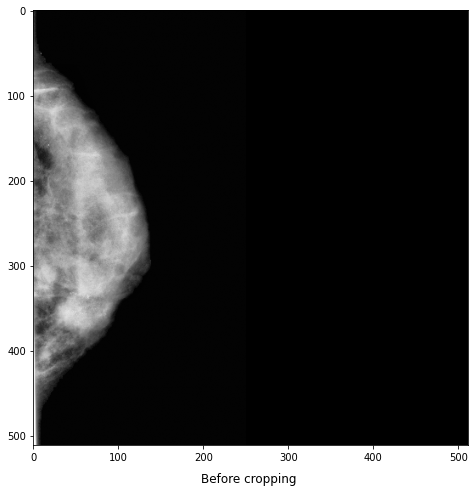

In [46]:
plt.figure(figsize = (50,8))
plt.imshow(res_x.numpy(), cmap="gray")
plt.title(f"Before cropping ", x=0.5, y=-0.1)

(512, 512, 3)


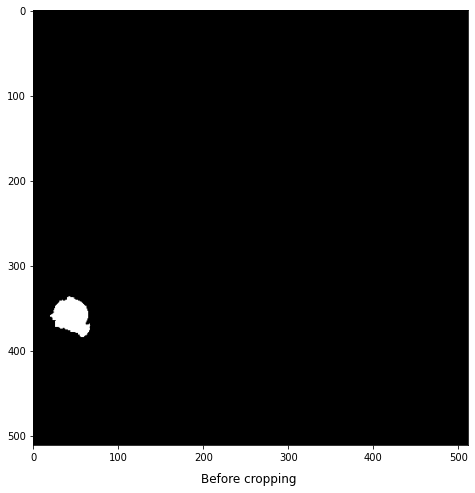

In [47]:
plt.figure(figsize = (50,8))
plt.imshow(res_y.numpy()[:,:,0], cmap="gray")
plt.title(f"Before cropping ", x=0.5, y=-0.1)
print(res_x.numpy().shape)

In [48]:
# res_y.numpy()[:,:,0].shape

In [49]:
# res_x.numpy().shape

In [50]:
prediction = unet.predict(test_ds)

In [51]:
# type(prediction)

In [52]:
# prediction.shape

In [53]:
# prediction[0].shape

(512, 512, 3)


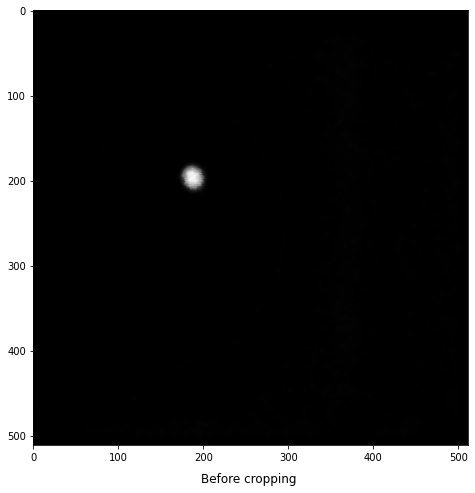

In [54]:
plt.figure(figsize = (50,8))
plt.imshow(prediction[i][:,:,0], cmap="gray")
plt.title(f"Before cropping ", x=0.5, y=-0.1)
print(res_x.numpy().shape)